In [1]:
import RtKernel as ker
import RtDlr as dlr
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    "font.size" : 8
})

Set parameters

In [2]:
m_chebyshev_order = 1
cutoff = 600#energy scale at which spectral density vanishes
phi = np.pi/4
beta = 10.
N_max = 100
delta_t = 0.1

#set the values of m that should be explored
nbr_discrete_points = list(map(int, [np.exp(0.135 * i) for i in range(15, 39,1)]))


Compute the error between continuous-frequency integration and the discrete approximation 

In [3]:
#compute array containing absolute time integrated error for each m
abs_time_integrated_error = [ker.DiscrError(m,m,N_max,delta_t,beta,cutoff).abs_error_time_integrated() for m in nbr_discrete_points]
#ignore integrated errors close to machine precision
delete_incs = [i for i, err in enumerate(abs_time_integrated_error) if abs(err) < 5.e-14]#identify indices in array which correspond to very small errors

error = np.delete(abs_time_integrated_error, delete_incs)#delete very small numbers from array of errors
nbr_discrete_points = np.delete(nbr_discrete_points,delete_incs)#delete also the corresponding point in the nbr_discrete_points array


Evaluate SVD and ID for fixed parameters

In [4]:
D = np.empty(len(nbr_discrete_points), dtype=object) # array for RtDlr objects
for i, m  in enumerate(nbr_discrete_points):
    D[i] = dlr.RtDlr(N_max, delta_t, beta, cutoff, m, m, error[i])

Plot Results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


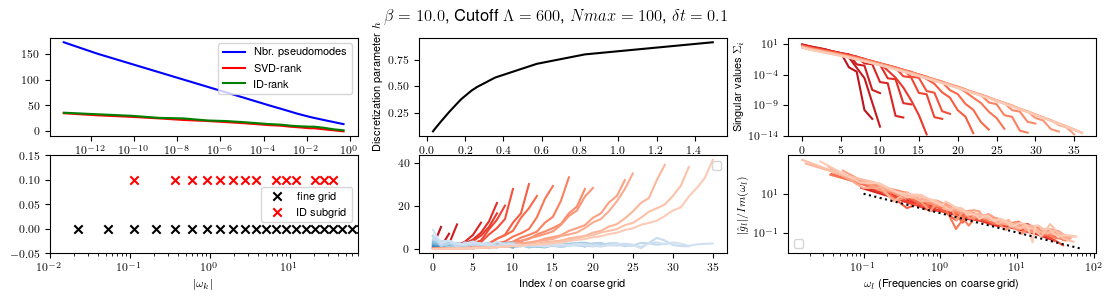

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(13.5,2.8))  # 1 row, 3 columns

fig.suptitle(r'$\beta = {}$'.format(beta) +  ',   Cutoff 'r'$\Lambda = {}$'.format(cutoff)+ ',   '+ r'$Nmax={}$'.format(N_max) + ',   '+ r'$\delta t={}$'.format(delta_t), fontsize = 12)
# Create a color gradient based on the index I
cmaps = [plt.get_cmap('Blues'), plt.get_cmap('Reds')]
colors_blue = cmaps[0](np.linspace(.8,0.2, len(nbr_discrete_points)))
colors_orange = cmaps[1](np.linspace(.8,0.2, len(nbr_discrete_points)))


axs[0,0].plot(error,2 * nbr_discrete_points, color = 'blue', label='Nbr. pseudomodes')
num_sing_vals = np.array([d.num_singular_values_above_threshold for d in D])
axs[0,0].plot(error,num_sing_vals, color = 'red', label= 'SVD-rank')
ID_rank = np.array([d.ID_rank for d in D])
axs[0,0].plot(error,ID_rank, color = 'green', label= 'ID-rank')
axs[0,0].set_xlabel(r'$||\epsilon||_2 = \int dt\, \epsilon_t$' + '  (' + r'$L_2$-' + 'norm of error)')
axs[0,0].legend()
axs[0,0].set_xscale('log')


h_vals = np.array([d.h for d in D])
axs[0,1].plot(1/np.log(1/error), h_vals, color = 'black')
axs[0,1].set_xlabel(r'$1/\log(\epsilon^{-1})$')
axs[0,1].set_ylabel('Discretization parameter ' + r'$h$')

for c,d in enumerate(D):
    singular_values = d.singular_values
    del_sing_vals = [i for i, sigma in enumerate(singular_values) if abs(sigma) < 1.e-14]
    singular_values = np.delete(singular_values,del_sing_vals)
    axs[0,2].plot(np.arange(len(singular_values)), singular_values, color = colors_orange[c])
axs[0,2].set_xlabel('Index ' + r'$i$')
axs[0,2].set_ylabel('Singular values ' + r'$\Sigma_i$')
axs[0,2].set_yscale('log')
axs[0,2].set_ylim(bottom = 1.e-14, top = 100)
#axs[0,2].text(15,1.e-2,'lighter = finer grid')

fine_grid = D[len(D)//2].fine_grid # fine grid at some index, here chosen to be len(D)//2
coarse_grid = D[len(D)//2].coarse_grid # coarse grid at some index, here chosen to be len(D)//2
axs[1,0].scatter(fine_grid,len(fine_grid) * [0], color = 'black', label = 'fine grid', marker='x',)
axs[1,0].scatter(coarse_grid,len(coarse_grid) * [0.1],  color = 'red', label = 'ID subgrid', marker='x',)
axs[1,0].set_ylim(bottom = -0.05, top = 0.15)
axs[1,0].set_xlim(left = 1.e-2, right = 70)
axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'$|\omega_k|$')
axs[1,0].legend()


for c,d in enumerate(D):
    couplings_eff = d.coupl_eff()
    coarse_grid = d.coarse_grid
    arg_sort_coarse = np.argsort(coarse_grid)
    axs[1,1].plot(np.arange(len(couplings_eff)), abs(couplings_eff[np.argsort(coarse_grid)]), color = colors_blue[c])
    axs[1,1].plot(np.arange(len(coarse_grid)), np.imag(coarse_grid[arg_sort_coarse] * np.exp(1.j * np.pi/4)), color = colors_orange[c])
    axs[1,2].plot(np.sort(coarse_grid), abs(couplings_eff[arg_sort_coarse])/np.imag(coarse_grid[arg_sort_coarse] * np.exp(1.j * phi)), color = colors_orange[c])

axs[1,1].set_xlabel('Index ' + r'$l$' + ' on coarse grid')
#axs[1,1].set_yscale('log')
axs[1,1].legend()
#axs[1,1].text(20,20, 'lighter = finer grid')

axs[1,2].set_ylabel(r'$|\hat{g}_l| / Im(\omega_l)$')
axs[1,2].set_xlabel(r'$\omega_l$' + ' (Frequencies on coarse grid)')
axs[1,2].set_yscale('log')
axs[1,2].set_xscale('log')
axs[1,2].legend(loc = 'lower left')
#axs[1,2].text(1,11,'lighter = finer grid \n Note log-log scale')
axs[1,2].plot(np.linspace(0.1,70), 1/np.linspace(0.1,70),linestyle = 'dotted', label= r'$\sim 1/|\omega_l|$', color = 'black')


